# Step 1: Check for TensorFlow GPU with CUDA


In [1]:
import tensorflow as tf

# Check if GPU is available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Check TensorFlow version
print("TensorFlow version: ", tf.__version__)

# Check if TensorFlow is built with CUDA
print("Is built with CUDA: ", tf.test.is_built_with_cuda())

# Check if the GPU is available and working
print("Is GPU available: ", tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None))

Num GPUs Available:  1
TensorFlow version:  2.10.0
Is built with CUDA:  True
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Is GPU available:  True


# Step 2: Prepare and Load Dataset


## 1. Loading and Sampling the Dataset:


In [2]:
import os
import random
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the path to the dataset
dataset_path = 'RealWaste/'
sampled_dataset_path = 'RealWaste_Sampled/'

# Define the folders
folders = [
    'Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 
    'Paper', 'Plastic', 'Textile Trash', 'Vegetation'
]

# Create the sampled dataset directory if it doesn't exist
if not os.path.exists(sampled_dataset_path):
    os.makedirs(sampled_dataset_path)

# Function to sample 10% of images from each folder
def sample_images(folder):
    folder_path = os.path.join(dataset_path, folder)
    sampled_folder_path = os.path.join(sampled_dataset_path, folder)
    
    # Create the folder in the sampled dataset directory
    if not os.path.exists(sampled_folder_path):
        os.makedirs(sampled_folder_path)
    
    # Get the list of all images in the folder
    images = os.listdir(folder_path)
    num_images = len(images)
    sample_size = max(1, num_images // 10)  # Ensure at least one image is selected
    
    # Randomly sample images
    sampled_images = random.sample(images, sample_size)
    
    # Copy sampled images to the new directory
    for image in sampled_images:
        shutil.copy(os.path.join(folder_path, image), os.path.join(sampled_folder_path, image))
    
    print(f"Sampled {len(sampled_images)} images from {folder}")

# Sample images from each folder
for folder in folders:
    sample_images(folder)

Sampled 46 images from Cardboard
Sampled 41 images from Food Organics
Sampled 42 images from Glass
Sampled 79 images from Metal
Sampled 49 images from Miscellaneous Trash
Sampled 50 images from Paper
Sampled 92 images from Plastic
Sampled 31 images from Textile Trash
Sampled 43 images from Vegetation


## 2. Data Augmentation and Displaying Augmented Images:


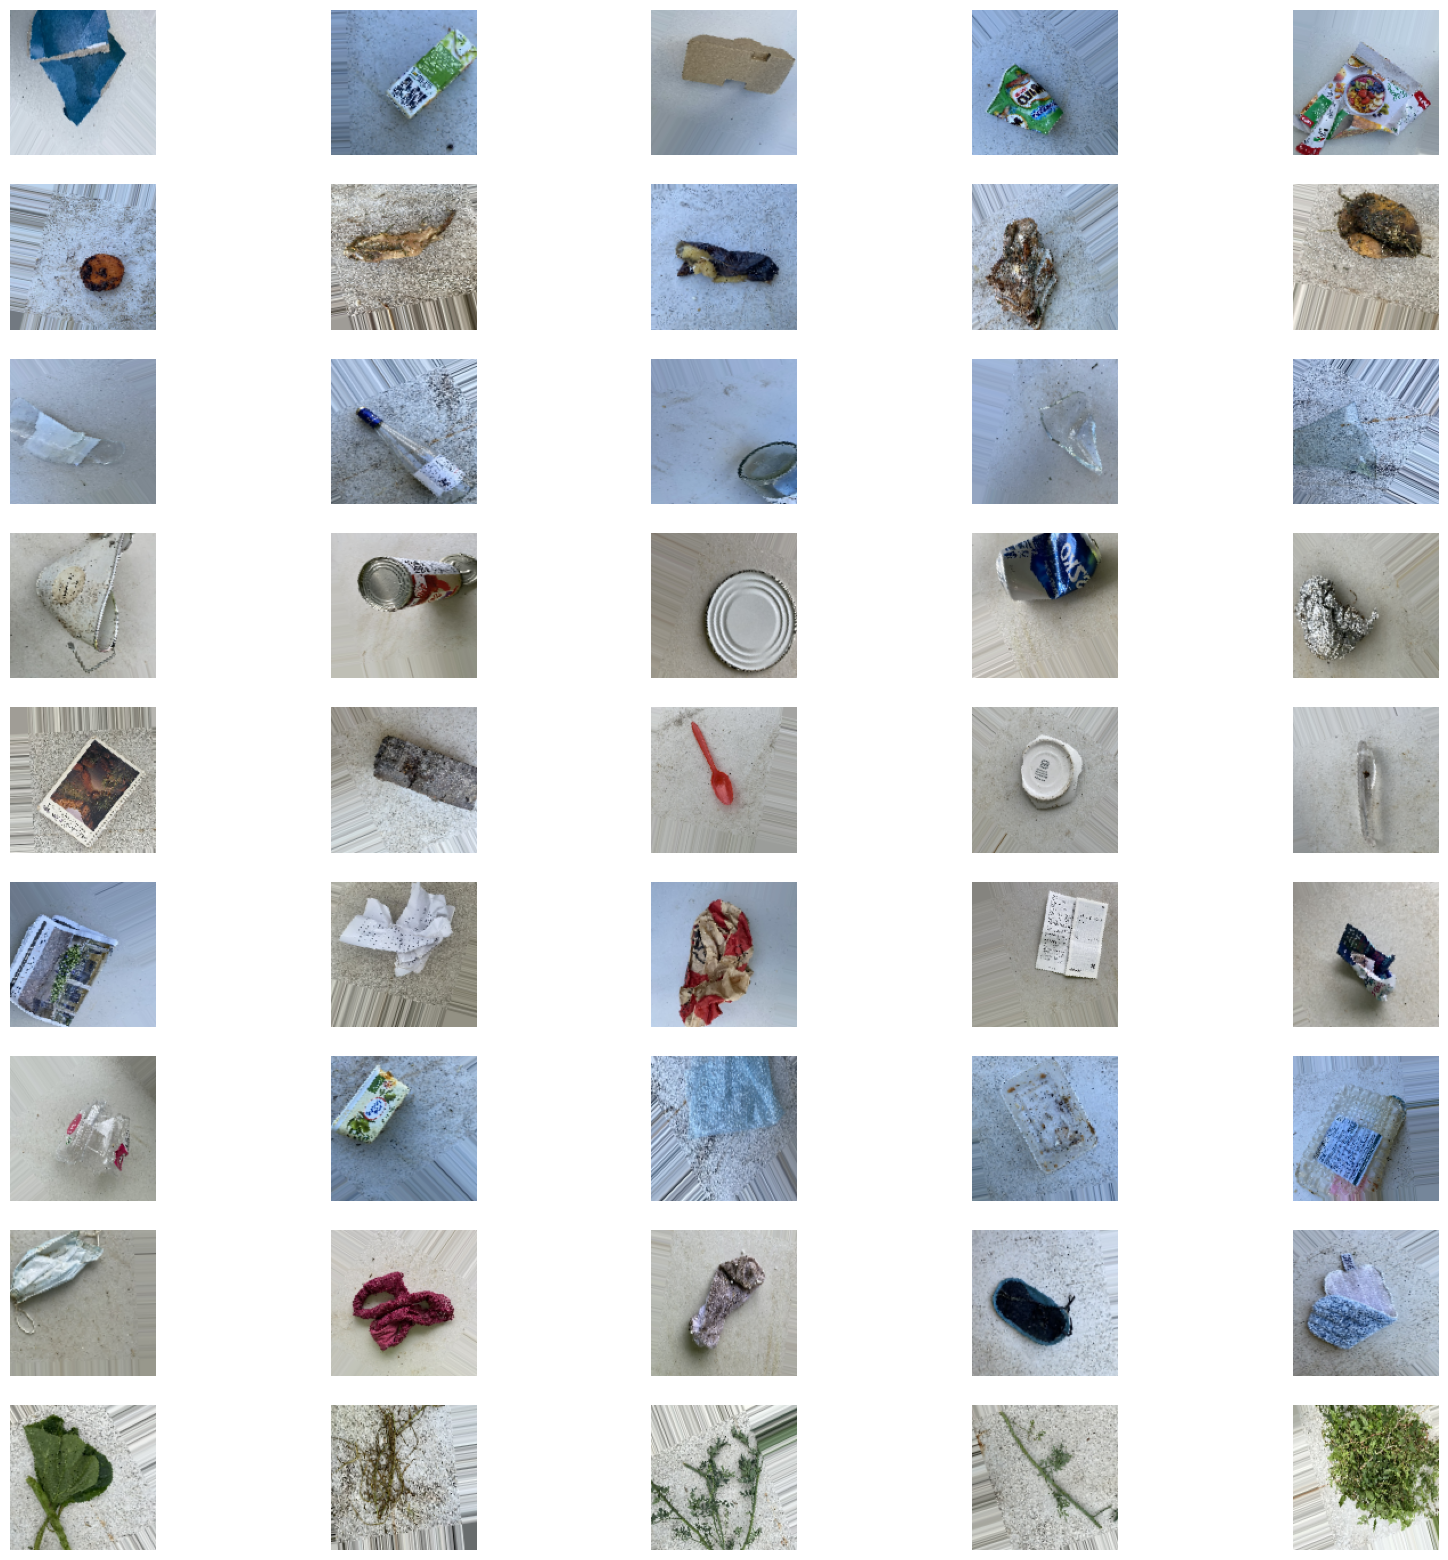

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Load and augment a batch of images
def augment_and_display_images_grid(folders, num_images=5):
    fig, axes = plt.subplots(len(folders), num_images, figsize=(20, 20))
    
    for j, folder in enumerate(folders):
        folder_path = os.path.join(sampled_dataset_path, folder)
        images = os.listdir(folder_path)
        
        for i, img_name in enumerate(random.sample(images, num_images)):
            img_path = os.path.join(folder_path, img_name)
            img = tf.keras.preprocessing.image.load_img(img_path, target_size=(128, 128))
            x = tf.keras.preprocessing.image.img_to_array(img)
            x = np.expand_dims(x, axis=0)
            
            # Generate augmented images
            aug_iter = datagen.flow(x, batch_size=1)
            aug_images = [next(aug_iter)[0].astype(np.uint8) for _ in range(1)]
            
            axes[j, i].imshow(aug_images[0])
            axes[j, i].axis('off')
    
    plt.show()

# Define the folders
folders = [
    'Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 
    'Paper', 'Plastic', 'Textile Trash', 'Vegetation'
]

# Display augmented images from multiple folders
augment_and_display_images_grid(folders)

### Justification:This code updates the previous function to display augmented images in a grid format, where each row corresponds to a different class of images. This allows for a comprehensive visualization of the augmentation effects across all specified categories, aiding in better understanding and validation of the augmentation process..

# Step 3: Building and Training the CNN Model


## 1. Import Necessary Libraries:


In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## 2. Set Up Data Generators:


In [5]:
# Define directories
train_dir = 'RealWaste_Sampled/'

# Data augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Using 20% of data for validation
)

# Data generator for training data with reduced batch size
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=8,  # Reduced batch size
    class_mode='categorical',
    subset='training'
)

# Data generator for validation data with reduced batch size
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=8,  # Reduced batch size
    class_mode='categorical',
    subset='validation'
)


# Print the number of images used in each generator
print(f"Number of training images: {train_generator.samples}")
print(f"Number of validation images: {validation_generator.samples}")

Found 723 images belonging to 9 classes.
Found 177 images belonging to 9 classes.
Number of training images: 723
Number of validation images: 177


## 3. Build the CNN Model:


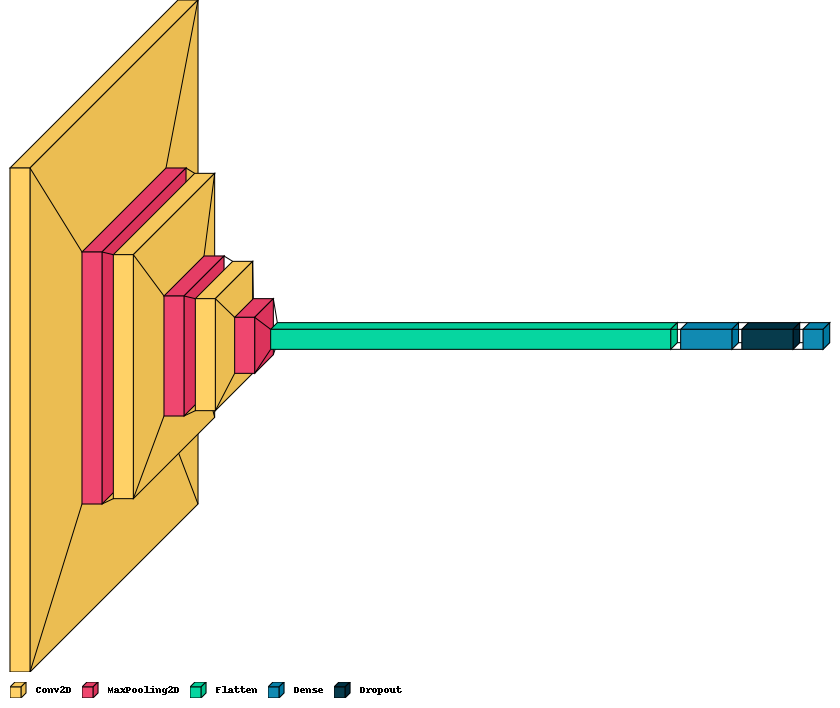

In [25]:
import visualkeras

# Assuming the model is already built and compiled
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(len(folders), activation='softmax')
])

# Visualize the model
visualkeras.layered_view(model, legend=True)

In [26]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [27]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 14, 14, 128)     

## 4. Train the Model:


In [28]:
from tensorflow.keras.callbacks import EarlyStopping

# Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with more epochs and early stopping
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=100,  # Increased number of epochs
    callbacks=[early_stopping]
)

Epoch 1/100
90/90 [==============================] - 6s 57ms/step - loss: 2.2199 - accuracy: 0.1692 - val_loss: 2.1427 - val_accuracy: 0.1989
Epoch 2/100
90/90 [==============================] - 5s 51ms/step - loss: 2.1481 - accuracy: 0.1720 - val_loss: 2.1408 - val_accuracy: 0.1818
Epoch 3/100
90/90 [==============================] - 5s 53ms/step - loss: 2.1348 - accuracy: 0.2070 - val_loss: 2.1390 - val_accuracy: 0.3011
Epoch 4/100
90/90 [==============================] - 5s 54ms/step - loss: 2.0997 - accuracy: 0.2476 - val_loss: 2.0698 - val_accuracy: 0.2273
Epoch 5/100
90/90 [==============================] - 5s 53ms/step - loss: 2.0238 - accuracy: 0.2727 - val_loss: 2.0456 - val_accuracy: 0.2841
Epoch 6/100
90/90 [==============================] - 6s 62ms/step - loss: 2.0127 - accuracy: 0.2699 - val_loss: 1.9392 - val_accuracy: 0.2614
Epoch 7/100
90/90 [==============================] - 6s 62ms/step - loss: 1.9678 - accuracy: 0.2811 - val_loss: 1.9657 - val_accuracy: 0.3409
Epoch 

## 5. Evaluate and Save the Model:


In [29]:
# Evaluate the model
loss, accuracy = model.evaluate(validation_generator)
print(f'Validation Accuracy: {accuracy * 100:.2f}%')

# Save the model
model.save('trash_classification_model.keras')

23/23 [==============================] - 1s 39ms/step - loss: 1.3971 - accuracy: 0.5254
Validation Accuracy: 52.54%


## 6. Plot Training and Validation Accuracy:


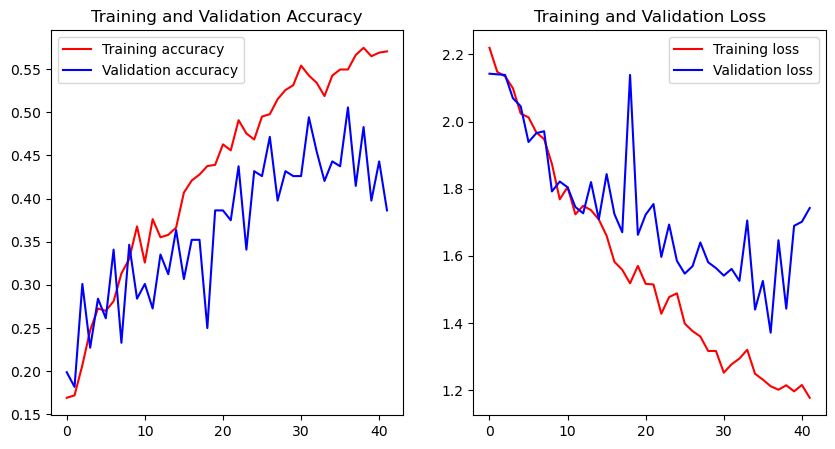

In [30]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

### Justifications:
1. Data Generators: We use ImageDataGenerator to load and augment images in batches, which helps in efficient memory management and introduces variations in the training data to improve model robustness.
2. Model Architecture: The CNN architecture with multiple convolutional and pooling layers is designed to capture spatial hierarchies in the images. Dropout is used to prevent overfitting.
3. Training and Evaluation: Training the model for multiple epochs allows it to learn patterns in the data, while evaluating on a validation set helps in monitoring the model's performance on unseen data. Saving the model ensures that we can reuse it without retraining.

# Code to Test the Model:


## 1. Load the Model:


In [31]:
from tensorflow.keras.models import load_model
import numpy as np
import tensorflow as tf
import random
import os

# Load the saved model
model = load_model('trash_classification_model.keras')

## 2. Function to Predict and Display Class:


In [32]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

# Function to load and predict the class of a random image from a folder
def predict_random_image(folder_path, original_class, class_names):
    images = os.listdir(folder_path)  # List all images in the folder
    img_name = random.choice(images)  # Select a random image
    img_path = os.path.join(folder_path, img_name)  # Get the full path of the image
    
    img = load_img(img_path, target_size=(128, 128))  # Load the image and resize it
    img_array = img_to_array(img)  # Convert the image to an array
    img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions to match the model input
    img_array /= 255.0  # Normalize the image
    
    prediction = model.predict(img_array)  # Make a prediction
    predicted_class = class_names[np.argmax(prediction)]  # Get the class name for the highest probability
    
    plt.imshow(img)  # Display the image
    plt.title(f"Original: {original_class}, Predicted: {predicted_class}")  # Display the original and predicted classes
    plt.axis('off')
    plt.show()
    
    return predicted_class  # Return the predicted class

## 3. Predict and Display Results for Each Class:


Predicting for class: Cardboard
1/1 [==============================] - 0s 65ms/step


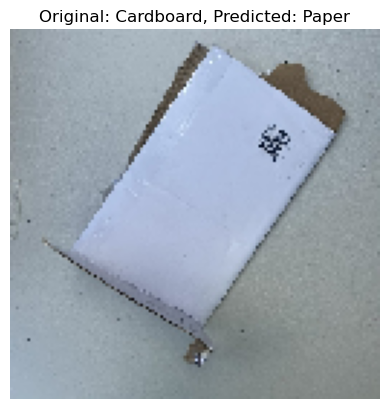

Original class: Cardboard, Predicted class: Paper
Predicting for class: Food Organics
1/1 [==============================] - 0s 17ms/step


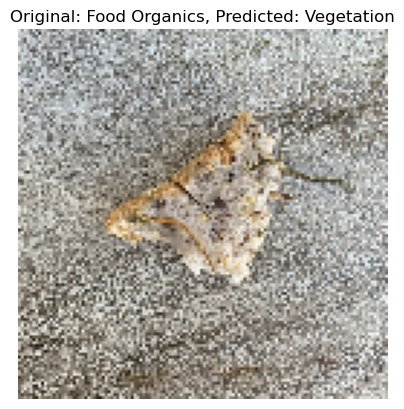

Original class: Food Organics, Predicted class: Vegetation
Predicting for class: Glass
1/1 [==============================] - 0s 18ms/step


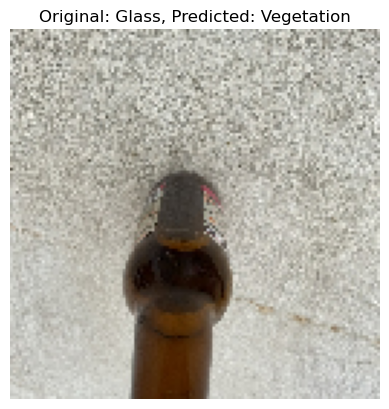

Original class: Glass, Predicted class: Vegetation
Predicting for class: Metal
1/1 [==============================] - 0s 19ms/step


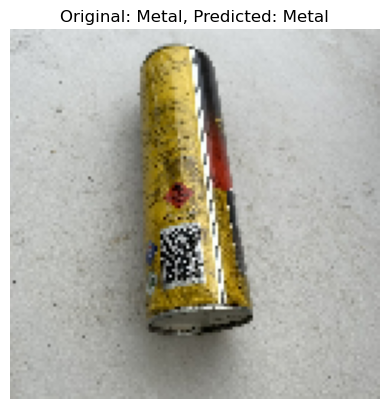

Original class: Metal, Predicted class: Metal
Predicting for class: Miscellaneous Trash
1/1 [==============================] - 0s 17ms/step


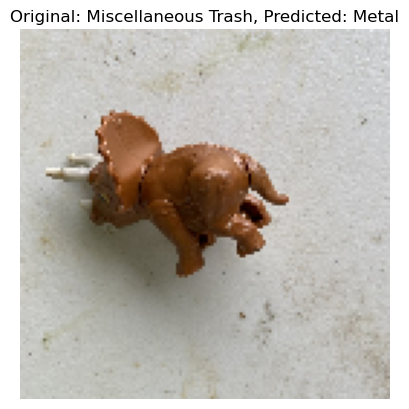

Original class: Miscellaneous Trash, Predicted class: Metal
Predicting for class: Paper
1/1 [==============================] - 0s 18ms/step


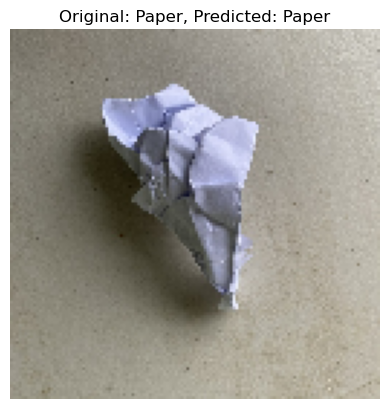

Original class: Paper, Predicted class: Paper
Predicting for class: Plastic
1/1 [==============================] - 0s 17ms/step


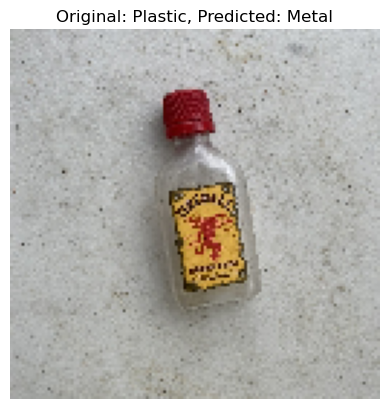

Original class: Plastic, Predicted class: Metal
Predicting for class: Textile Trash
1/1 [==============================] - 0s 18ms/step


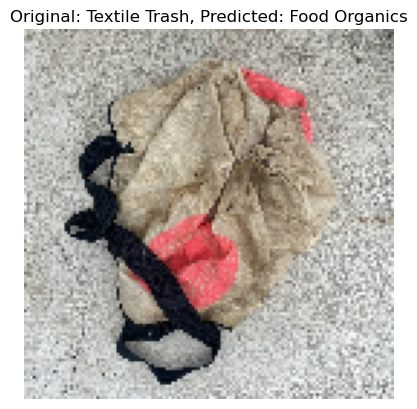

Original class: Textile Trash, Predicted class: Food Organics
Predicting for class: Vegetation
1/1 [==============================] - 0s 18ms/step


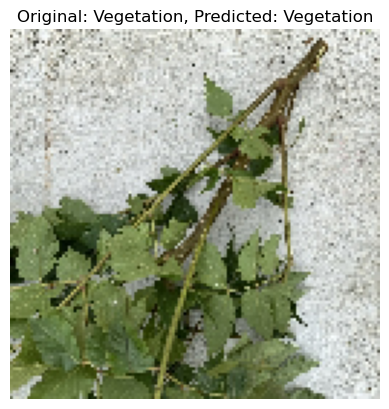

Original class: Vegetation, Predicted class: Vegetation


In [33]:
# Define the class names (folders)
class_names = [
    'Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 
    'Paper', 'Plastic', 'Textile Trash', 'Vegetation'
]

# Define the path to the sampled dataset
sampled_dataset_path = 'RealWaste_Sampled/'

# Predict and display the results for each class
for class_name in class_names:
    folder_path = os.path.join(sampled_dataset_path, class_name)  # Path to the specific class folder
    print(f"Predicting for class: {class_name}")  # Indicate which class is being predicted
    predicted_class = predict_random_image(folder_path, class_name, class_names)  # Make a prediction
    print(f"Original class: {class_name}, Predicted class: {predicted_class}")  # Print the original and predicted classes

## Explanation:
1. Loading the Model: The load_model function is used to load the previously saved model.
2. Prediction Function: The predict_random_image function loads a random image from the specified folder, preprocesses it, and uses the loaded model to predict the class. The function then displays the image with the predicted class.
3. Testing Each Class: The code iterates over each class folder, calls the prediction function, and prints the prediction results.

# Calculate Class-wise Accuracy:

## 1. Load the Model:


In [34]:
from tensorflow.keras.models import load_model
import numpy as np
import tensorflow as tf
import random
import os

# Load the saved model
model = load_model('trash_classification_model.keras')


## 2. Function to Predict and Calculate Accuracy:


In [35]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Function to predict the class of all images in a folder and calculate accuracy
def evaluate_class_accuracy(folder_path, original_class, class_names):
    images = os.listdir(folder_path)  # List all images in the folder
    correct_predictions = 0
    total_predictions = len(images)
    
    for img_name in images:
        img_path = os.path.join(folder_path, img_name)  # Get the full path of the image
        
        img = load_img(img_path, target_size=(128, 128))  # Load the image and resize it
        img_array = img_to_array(img)  # Convert the image to an array
        img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions to match the model input
        img_array /= 255.0  # Normalize the image
        
        prediction = model.predict(img_array)  # Make a prediction
        predicted_class = class_names[np.argmax(prediction)]  # Get the class name for the highest probability
        
        if predicted_class == original_class:
            correct_predictions += 1
    
    accuracy = correct_predictions / total_predictions
    return accuracy

## 3. Evaluate Accuracy for Each Class:


In [36]:
# Define the class names (folders)
class_names = [
    'Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 
    'Paper', 'Plastic', 'Textile Trash', 'Vegetation'
]

# Define the path to the sampled dataset
sampled_dataset_path = 'RealWaste_Sampled/'

# Evaluate and store the accuracy for each class
def calculate_class_accuracies(class_names, dataset_path):
    class_accuracies = {}

    for class_name in class_names:
        folder_path = os.path.join(dataset_path, class_name)  # Path to the specific class folder
        accuracy = evaluate_class_accuracy(folder_path, class_name, class_names)  # Calculate accuracy
        class_accuracies[class_name] = accuracy  # Store the accuracy
    
    return class_accuracies

# Calculate accuracies
class_accuracies = calculate_class_accuracies(class_names, sampled_dataset_path)

# Display the accuracies
class_accuracies

1/1 [==============================] - 0s 23ms/step


{'Cardboard': 0.6385542168674698,
 'Food Organics': 0.5316455696202531,
 'Glass': 0.46153846153846156,
 'Metal': 0.86,
 'Miscellaneous Trash': 0.14736842105263157,
 'Paper': 0.4536082474226804,
 'Plastic': 0.4147727272727273,
 'Textile Trash': 0.3,
 'Vegetation': 0.9878048780487805}

### Accuracy for each class:

| Class Property        | Value |
|-----------------------|-------|
| Cardboard             | 0.639 |
| Food Organics         | 0.532 |
| Glass                 | 0.462 |
| Metal                 | 0.860 |
| Miscellaneous Trash   | 0.147 |
| Paper                 | 0.454 |
| Plastic               | 0.415 |
| Textile Trash         | 0.300 |
| Vegetation            | 0.988 |